# **Speech Emotion Recognition (Classification) using Deep LSTM**
***Real-time implementation of the SER model***
---



### ABSTRACT
This implementation of the speech emotion recognition (SER) model aims to analyze speech audio input in real-time, identify and present the emotions expressed.

The model, an LSTM-based deep learning network with an accuracy of 83%, has learned to accurately classify emotions conveyed in long sequences of speech features extracted from audio signals.
The system records audio input, creates a temporary `.wav` file, preprocesses it, and presents the distribution of detected emotions in the speech. The chosen sequence length for analysis is 7.1 seconds.
The process continues as long as continuous speech is detected. If there is silence for 2 seconds or more at the end of a sentence, the process stops. At the end of a session, a summary is presented, providing the mean values of all emotions recognized throughout the session.


### LIBRARIES
Import the necessary Python libraries and install any missing dependencies.


In [1]:
%%capture
!pip install pydub noisereduce pyaudio json-tricks

In [2]:
%%capture
import numpy as np
import librosa
from pydub import AudioSegment, effects
import noisereduce as nr
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython.display as ipd


# **LOAD MODEL**
Loading the speech emotion recognition LSTM model and weights.

In [3]:
saved_model_path = 'output/model.json'
saved_weights_path = 'output/model.weights.h5'

with open(saved_model_path, 'r') as json_file:
    json_savedModel = json_file.read()

model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

model.compile(loss='categorical_crossentropy',
              optimizer='RMSProp',
              metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 729, 64)        │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,024 (211.03 KB)

 Trainable params: 54,024 (211.03 KB)

 Non-trainable params: 0 (0.00 B)

None


# **DATA PREPROCESSING**

Speech features are extracted are:
1.   Energy - Root Mean Square (RMS)
2.   Zero Crossed Rate (ZCR)
3.   Mel-frequency cepstral coefficients (MFCCs) 





In [4]:
def pre_process(file_path, frame_length=2048, hop_length=512):
    _, sr = librosa.load(path=file_path, sr=None)
    raw_sound = AudioSegment.from_file(file_path, duration=None)
    normalized_sound = effects.normalize(raw_sound, headroom=5.0)
    normal_x = np.array(normalized_sound.get_array_of_samples(), dtype='float32')
    final_x = nr.reduce_noise(normal_x, sr=sr)
    f1 = librosa.feature.rms(y=final_x, frame_length=frame_length, hop_length=hop_length, center=True,
                             pad_mode='reflect').T
    f2 = librosa.feature.zero_crossing_rate(final_x, frame_length=frame_length, hop_length=hop_length,
                                            center=True).T
    f3 = librosa.feature.mfcc(y=final_x, sr=sr, S=None, n_mfcc=13, hop_length=hop_length).T  # MFCC   
    x = np.concatenate((f1, f2, f3), axis=1)
    x_3d = np.expand_dims(x, axis=0)
    return x_3d

# **ADDITIONAL SETUP**
- An **emotion list** is defined to translate the model prediction output to a readable form.

- `is_silent` function is executed as a boolean state if silence of sequential audio was found. `is_silent` returns `True` when the maximum signal within the sequence is less than the threshold value defined.

In [5]:
emotions = {
    0: 'neutral',
    1: 'calm',
    2: 'happy',
    3: 'sad',
    4: 'angry',
    5: 'fearful',
    6: 'disgust',
    7: 'surprised'
}
emotion_list = list(emotions.values())


def is_silent(data):
    return max(data) < 100


# **REAL-TIME IMPLEMENTATION**

This implementation of an LSTM Speech Emotion Recognition model carries out a real-time emotion prediction of an audio input, recorded from the soundcard of the platform.
The process includes the following:


## **VARIABLES EXPLAINED**
RATE = Sample rate = 24414 which is the sample rate of most of the model's train data.
CHUNK = A batch of sequential samples to process at once. Similar to 'hop_length' by `librosa`, defined 512.
FORMAT = Sampling size and format, 32bit as in the model.
CHANNELS = 1 for mono, a standard of audio recording in PC / cellphones.

Session Initiated: 
ongoing recording.
* done recording
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


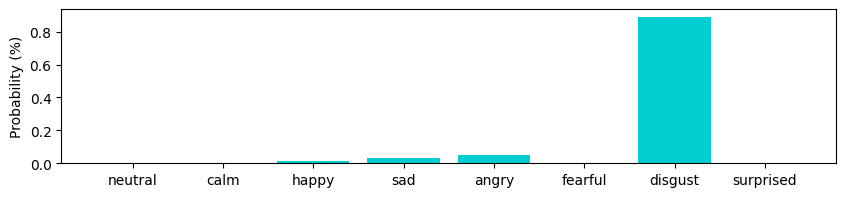

Max emotion in this iteration: disgust
----------------------------------------------------------------------------------------------------
ongoing recording.
* done recording
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


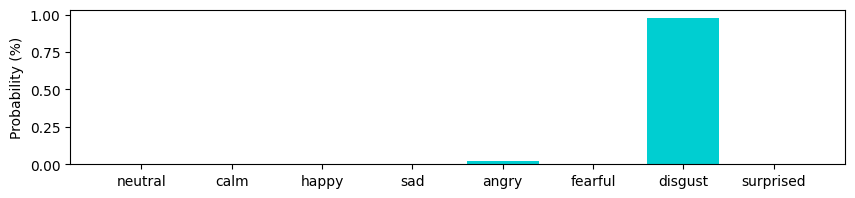

Max emotion in this iteration: disgust
----------------------------------------------------------------------------------------------------
Session ended:


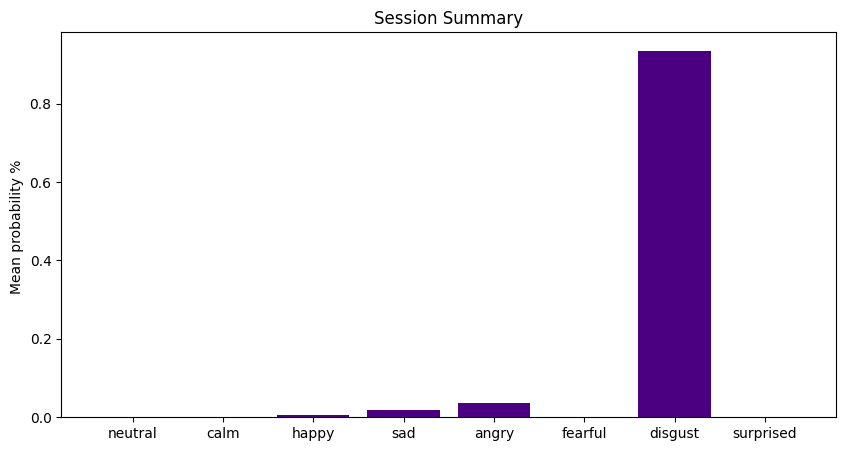

Emotions analyzed for: 15.9879 seconds


In [6]:
import pyaudio
import wave
from array import array
import struct
import time

# Initialize variables
RATE = 24414
CHUNK = 512
RECORD_SECONDS = 7.1

FORMAT = pyaudio.paInt32
CHANNELS = 1
WAVE_OUTPUT_FILE = "1.wav"

# Open an input channel
p = pyaudio.PyAudio()
stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

data = array('h', np.random.randint(size=512, low=0, high=500))

print("Session Initiated: ")
total_predictions = []
tic = time.perf_counter()

while not is_silent(data):
    print("ongoing recording.")
    frames = []
    data = np.nan

    time_steps = int(RATE / CHUNK * RECORD_SECONDS)  # => 339

    for i in range(0, time_steps):
        data = array('l', stream.read(CHUNK))
        frames.append(data)

        wf = wave.open(WAVE_OUTPUT_FILE, 'wb')
        wf.setnchannels(CHANNELS)
        wf.setsampwidth(p.get_sample_size(FORMAT))
        wf.setframerate(RATE)
        wf.writeframes(b''.join(frames))

    print("* done recording")

    x = pre_process(WAVE_OUTPUT_FILE)
    predictions = model.predict(x)
    pred_list = list(predictions)
    pred_np = np.squeeze(np.array(pred_list).tolist(), axis=0)
    total_predictions.append(pred_np)

    fig = plt.figure(figsize=(10, 2))
    plt.bar(emotion_list, pred_np, color='darkturquoise')
    plt.ylabel("Probability (%)")
    plt.show()
    max_emo = np.argmax(predictions)
    print('Max emotion in this iteration:', emotions.get(max_emo, -1))

    print(100 * '-')

    last_frames = np.array(
        struct.unpack(str(96 * CHUNK) + 'B', np.stack((frames[-1], frames[-2], frames[-3], frames[-4],
                                                       frames[-5], frames[-6], frames[-7], frames[-8],
                                                       frames[-9], frames[-10], frames[-11], frames[-12],
                                                       frames[-13], frames[-14], frames[-15], frames[-16],
                                                       frames[-17], frames[-18], frames[-19], frames[-20],
                                                       frames[-21], frames[-22], frames[-23], frames[-24]),
                                                      axis=0))).astype(dtype='b')

    if is_silent(last_frames):
        break

toc = time.perf_counter()
stream.stop_stream()
stream.close()
p.terminate()
wf.close()
print('Session ended:')

total_predictions_np = np.mean(np.array(total_predictions).tolist(), axis=0)
fig = plt.figure(figsize=(10, 5))
plt.bar(emotion_list, total_predictions_np, color='indigo')
plt.ylabel("Mean probability % ")
plt.title("Session Summary")
plt.show()

print(f"Emotions analyzed for: {(toc - tic):0.4f} seconds")

